### S.Z. Muller
# Code to generate figure 6 in the paper (Continual Learning in a Multi-Layer Network of an Electric Fish, Cell 2019). 

## instructions:
### 1) Install the NEURON module (https://www.neuron.yale.edu/neuron/download)
### 2) Download and expand this archive. Compile the mod files with nrnivmodl (Neuron 7.7 and above).
### 3) Run this jupyter notebook code (actuall simulation may take a few minutes) and follow the instructions for specific plots.


In [6]:
# import neuron
# neuron.load_mechanisms('/Users/..../[name of folder containing the compiled files]')
from neuron import h, gui
import numpy as np
%matplotlib tk
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random 
import time


In [7]:
run general_fun.ipynb

In [8]:
h.xopen("MG_reconstructed_by_Nate_Sawtell");

len_seg = 30
for sec in h.all:
    sec.nseg = np.int(np.ceil(sec.L/len_seg))
    if not (sec.nseg % 2):
        sec.nseg = sec.nseg + 1
        
# def create_section_lists(vml_thresh = 200):
vml_thresh = 100
h.distance(sec=h.soma)

vml = h.SectionList()
dml = h.SectionList()
exclude_comp = ['apic[0]']
for sec in h.apical:
    if sec.hname() not in exclude_comp:
        dist_from_soma = h.distance(sec(.5))
        if dist_from_soma < vml_thresh:
            vml.append(sec=sec)
        elif dist_from_soma >= vml_thresh:
            dml.append(sec=sec)

h.celsius = 20
set_init = -65
h.v_init = set_init

# insert channels

for sec in h.all:
    sec.Ra =100    # Axial resistance in Ohm * cm
    sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
for sec in h.basal:
        sec.insert('pas')
        sec.g_pas = 0.0003
        sec.e_pas = set_init
for sec in h.somatic:
        sec.insert('pas')
        sec.g_pas = 0.0003
        sec.e_pas = set_init

In [9]:
def make_MG(TTX = False, TTX_axon = False, TTX_apical = False, set_init = -65):

    axon_no_hh = ['axon[0]']
    for sec in h.axonal:
        if any(word in sec.hname() for word in axon_no_hh):  
            sec.insert('pas')
            sec.g_pas = 0.0003
            sec.e_pas = set_init
        else:
            sec.insert('hh')
            sec.gl_hh = 0.0003
            sec.el_hh = set_init - 5 
            if TTX or TTX_axon:      
                sec.gnabar_hh = 0
                sec.gkbar_hh =  0
            else:
                sec.gnabar_hh = 4 
                sec.gkbar_hh =  0.5  

    apic_no_syn = ['apic[0]'] 
    for sec in h.apical:
        if sec.hname() in apic_no_syn:
            sec.insert('pas')
            sec.g_pas = 0.0003
            sec.e_pas = set_init
        else:  
            sec.insert('hh')
            sec.gl_hh = 0.0003
            sec.el_hh = set_init  
            sec.insert('cal') 
            if TTX or TTX_apical: 
                sec.gnabar_hh = 0
                sec.gkbar_hh =  0
                sec.gcalbar_cal =  0 
            else:
                sec.gnabar_hh = 0.1 
                sec.gkbar_hh =  0.008 
                sec.gcalbar_cal =  0.073


In [10]:
make_MG(TTX = False, TTX_axon = False, TTX_apical = False, set_init = -65)

# Figure 6 B,D

### For 6B set Nspk_up_Bspk_down = True

### For 6D top set Inh = True
### For 6D bottom set Inh = True, and set pf_exc_canc_inh = True

In [8]:
np.random.seed(seed=1)

t = time.time()

nr_runs = 10
stim_dur = 10000
trial_length = 200
eliminate_trials = 1
record_conduc = False

Inh = False
pf_exc_canc_inh = False
Nspk_up_Bspk_down = False

if Nspk_up_Bspk_down:
    Inh = False
    pf_exc_canc_inh = False
    
if pf_exc_canc_inh:
    Nspk_up_Bspk_down = False
    
all_runs = []
all_runs_apic = []
for ii in range(nr_runs):
    results_all = run_sim(trial_length = trial_length, Inh = Inh, pf_exc_canc_inh = pf_exc_canc_inh,\
                          Nspk_up_Bspk_down = Nspk_up_Bspk_down, stim_dur = stim_dur, record_conduc = record_conduc)
    all_trials,trial_length_dt = trace_to_trials(results_all['v_vec_soma'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic,trial_length_dt = trace_to_trials(results_all['v_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)

    all_runs = all_runs+all_trials
    all_runs_apic = all_runs_apic+all_trials_apic

all_trials = all_runs

elapsed = time.time() - t
print(elapsed)

232.7329080104828


# plots 
### for better view, set y_range_nspk to match the range of the data

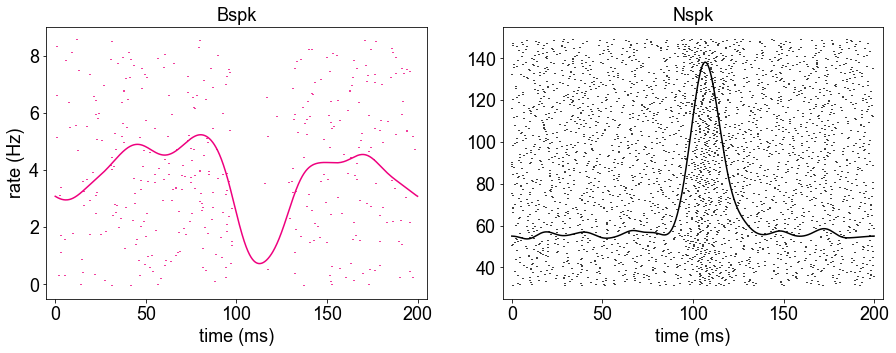

In [10]:
%matplotlib inline
spk_times_soma = turn_trace_to_spk(all_trials, min_hight_nspk = -60, min_hight_bspk = -40,\
                                   prom_nspk = .5, prom_bspk = 15)
spk_rates_soma = make_spk_rate(spk_times_soma, trial_length_dt,Method = 'wrap',Nspk_time_ms = 5, Bspk_time_ms = 8)

plot_patch = False
plot_mean_patch = False
mean_inh_input = 100
std_inh_input = 10

y_range_bspk = [-0.5,9]
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fs = 18
fig, ax = plt.subplots(1,2,figsize=(15,5))
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
plt.rcParams['font.family'] = 'Arial'

Bspk_color = (238/255, 0, 126/255)
Patch_color = '0.85' #(152/255,251/255,152/255)

ax[0].plot(spk_rates_soma['Bspk_rate_smoothed'],color = Bspk_color,Linewidth = 1.5)
plt.sca(ax[0])
locs, labels = plt.xticks()
dt = 0.025
ticknames = np.require(locs*dt,dtype=np.int)
plt.xticks(locs, ticknames)
plt.xlim([-5/dt,205/dt])
ax[0].set_xlabel('time (ms)',fontsize = fs)
ax[0].set_ylabel('rate (Hz)',fontsize = fs)
ax[0].set_ylim(y_range_bspk);
ax[0].set_title('Bspk',fontsize = fs)

if plot_patch:
    nr_extr = 0.6
    rect1 = matplotlib.patches.Rectangle(((mean_inh_input-std_inh_input)/dt,(y_range_bspk[0]+nr_extr)), 2*std_inh_input/dt, (y_range_bspk[1]-y_range_bspk[0]-2*nr_extr), color=Patch_color)
    ax[0].add_patch(rect1)
    if plot_mean_patch:
        plt.vlines(mean_inh_input/dt, y_range_bspk[0]+nr_extr,y_range_bspk[1]-nr_extr,color = '0.7')

ax2 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis
plt.sca(ax2)
for i, spike_times_vec in enumerate(spk_times_soma['peaks_bspk_all']):
    plt.vlines(spike_times_vec, i + 0, i + 2,color = Bspk_color)
ax2.axis('off');


ax[1].plot(spk_rates_soma['Nspk_rate_smoothed'],'k',Linewidth = 1.5)
plt.sca(ax[1])

y_range_nspk = [25,155]
plt.xticks(locs, ticknames)
plt.xlim([-5/dt,205/dt])
ax[1].set_xlabel('time (ms)',fontsize = fs)
ax[1].set_ylim(y_range_nspk);
ax[1].set_title('Nspk',fontsize = fs)
if plot_patch:
    nr_extr = 2.5
    rect1 = matplotlib.patches.Rectangle(((mean_inh_input-std_inh_input)/dt,y_range_nspk[0]+nr_extr), 2*std_inh_input/dt, (y_range_nspk[1]-y_range_nspk[0]-2*nr_extr), color=Patch_color)
    ax[1].add_patch(rect1)
    if plot_mean_patch:
        plt.vlines(mean_inh_input/dt, y_range_nspk[0]+nr_extr,y_range_nspk[1]-5,color = '0.7')

ax4 = ax[1].twinx()  # instantiate a second axes that shares the same x-axis
for i, spike_times_vec in enumerate(spk_times_soma['peaks_nspk_all']):
    ax4.vlines(spike_times_vec, i + 0.5, i + 1.5,'k')
ax4.axis('off');



### Plots not shown in paper. These are similar to paper, but here we added averaging with less smoothing, and added 'membrane potential raw traces' as well

132
223
395
183


(-1, 40)

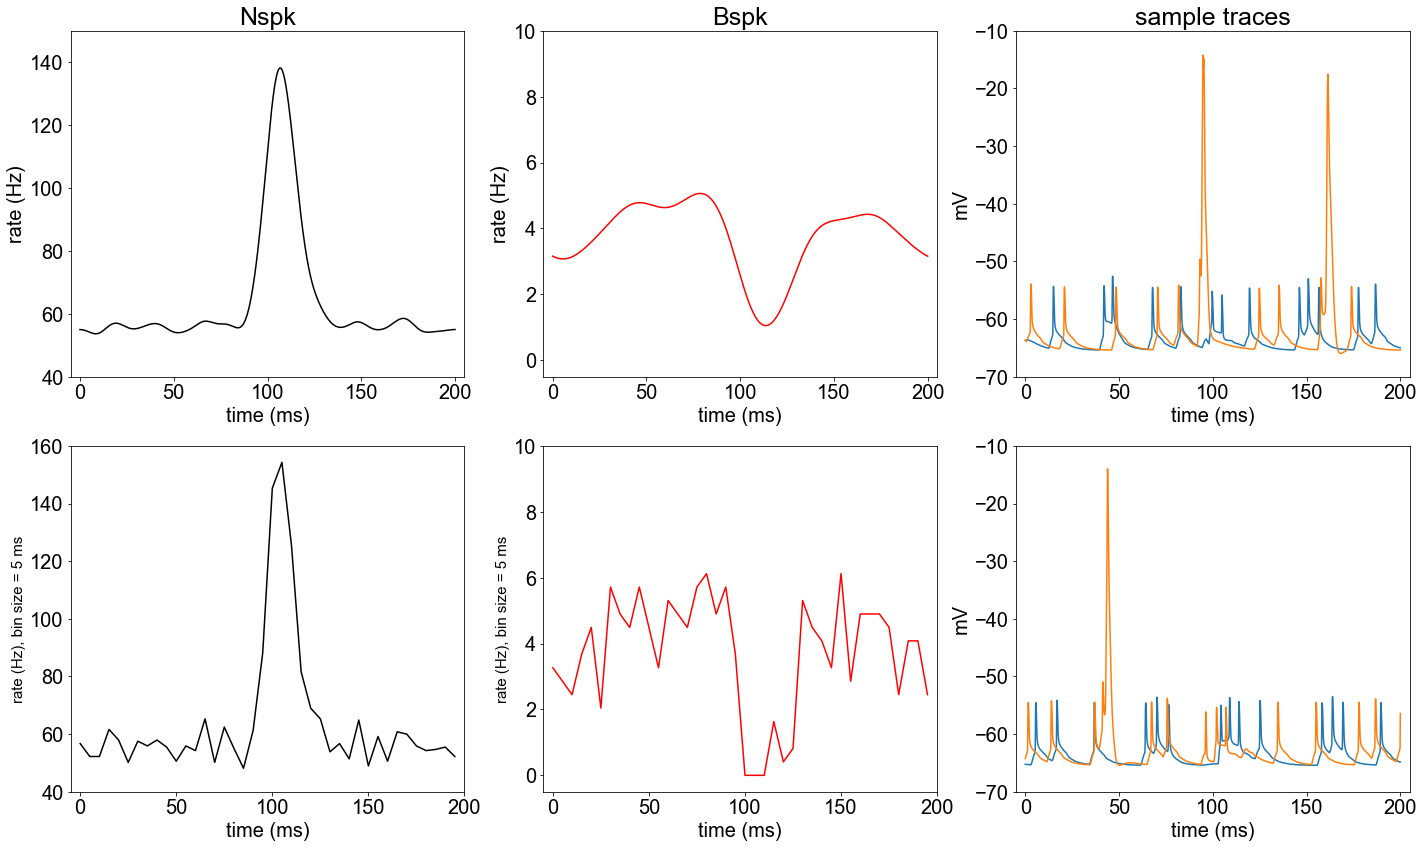

In [17]:
spk_times_soma = turn_trace_to_spk(all_trials, min_hight_nspk = -60, min_hight_bspk = -40,\
                                   prom_nspk = .5, prom_bspk = 15)
spk_rates_soma = make_spk_rate(spk_times_soma, trial_length_dt,Method = 'wrap',Nspk_time_ms = 5, Bspk_time_ms = 10)

bins_ms = 5 #ms
nr_iter = len(all_trials)
bin_Nspk = bin_data(spk_rates_soma['Nspk_number'],eliminate_trials = 0,trial_length = bins_ms)
bin_Bspk = bin_data(spk_rates_soma['Bspk_number'],eliminate_trials = 0,trial_length = bins_ms)

fs = 20
ts = 25

%matplotlib inline
fig = plt.figure(figsize=(24,14)) # Default figsize is (8,6)
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)

plt.subplot(2,3,3)
rnd_num = np.random.randint(0,len(all_trials),2);
for ii in rnd_num:
    print(ii)
    plt.plot(all_trials[ii])
locs, labels = plt.xticks()
dt = 0.025
ticknames = np.require(locs*dt,dtype=np.int)
plt.xticks(locs, ticknames)
plt.ylabel('mV', fontsize=fs)
plt.xlabel('time (ms)', fontsize=fs)
plt.title('sample traces', fontsize=ts)
plt.ylim([-70,-10])
plt.xlim([-5/dt,205/dt])

plt.subplot(2,3,6)
rnd_num = np.random.randint(0,len(all_trials),2);
for ii in rnd_num:
    print(ii)
    plt.plot(all_trials[ii])
locs, labels = plt.xticks()
dt = 0.025
ticknames = np.require(locs*dt,dtype=np.int)
plt.xticks(locs, ticknames)
plt.ylabel('mV', fontsize=fs)
plt.xlabel('time (ms)', fontsize=fs)
plt.ylim([-70,-10])
plt.xlim([-5/dt,205/dt])

plt.subplot(2,3,1)
plt.plot(spk_rates_soma['Nspk_rate_smoothed'],'k')
locs, labels = plt.xticks()
dt = 0.025
ticknames = np.require(locs*dt,dtype=np.int)
plt.xticks(locs, ticknames)
plt.ylabel('rate (Hz)', fontsize=fs)
plt.xlabel('time (ms)', fontsize=fs)
plt.ylim([20,150])
plt.title('Nspk', fontsize=ts)
plt.xlim([-5/dt,205/dt])

plt.subplot(2,3,4)
plt.plot(bin_Nspk/nr_iter/(bins_ms*0.001),'k')
locs, labels = plt.xticks()
ticknames = np.require(locs*bins_ms,dtype=np.int)
plt.xticks(locs, ticknames)
plt.ylabel('rate (Hz), bin size = {} ms'.format(bins_ms), fontsize=15)
plt.xlabel('time (ms)',fontsize=fs)
plt.ylim([20,160])
plt.xlim([-1,len(bin_Nspk)])

plt.subplot(2,3,2)
plt.plot(spk_rates_soma['Bspk_rate_smoothed'],'r')
locs, labels = plt.xticks()
dt = 0.025
ticknames = np.require(locs*dt,dtype=np.int)
plt.xticks(locs, ticknames)
plt.ylabel('rate (Hz)', fontsize=fs)
plt.xlabel('time (ms)', fontsize=fs)
plt.ylim([-0.5, 10])
plt.title('Bspk', fontsize=ts)
plt.xlim([-5/dt,205/dt])

plt.subplot(2,3,5)
plt.plot(bin_Bspk/nr_iter/(bins_ms*0.001),'r')
locs, labels = plt.xticks();
ticknames = np.require(locs*bins_ms,dtype=np.int)
plt.xticks(locs, ticknames)
plt.ylabel('rate (Hz), bin size = {} ms'.format(bins_ms), fontsize=15)
plt.xlabel('time (ms)', fontsize=fs)
plt.ylim([-0.5,10])
plt.xlim([-1,len(bin_Bspk)])


# Figure 6C

In [11]:
np.random.seed(seed=3)
t = time.time()

nr_runs = 10
stim_dur = 10000
trial_length = 200
eliminate_trials = 1

bl_dend = True
bl_apical = True
bl_inh = True
remove_Inh = False
Nspk_down_Bspk_up = True
if Nspk_down_Bspk_up:
    remove_Inh = True
    
all_runs = []
all_runs_apic = []
for ii in range(nr_runs):
    results_all = run_sim_bse(trial_length = trial_length, remove_Inh = remove_Inh,\
                          Nspk_down_Bspk_up = Nspk_down_Bspk_up, bl_dend = bl_dend, bl_apical = bl_apical, bl_inh = bl_inh, stim_dur = stim_dur)

    all_trials,trial_length_dt = trace_to_trials(results_all['v_vec_soma'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)
    all_trials_apic,trial_length_dt = trace_to_trials(results_all['v_vec_apic'].to_python(),eliminate_trials = eliminate_trials,\
                                                 trial_length = trial_length)

    all_runs = all_runs+all_trials
    all_runs_apic = all_runs_apic+all_trials_apic

all_trials = all_runs

elapsed = time.time() - t
print(elapsed)

759.8029630184174


# plots 
### for better view, set y_range_nspk to match the range of the data

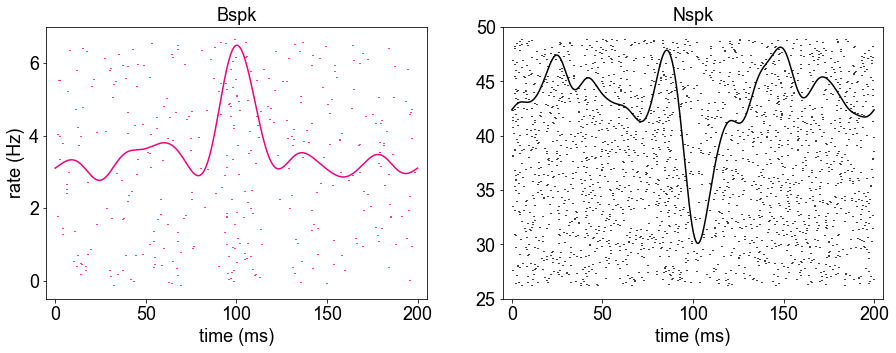

In [13]:
%matplotlib inline
spk_times_soma = turn_trace_to_spk(all_trials, min_hight_nspk = -60, min_hight_bspk = -40,\
                                   prom_nspk = .5, prom_bspk = 15)
spk_rates_soma = make_spk_rate(spk_times_soma, trial_length_dt,Method = 'wrap',Nspk_time_ms = 5, Bspk_time_ms = 8)

plot_patch = False
plot_mean_patch = False
mean_inh_input = 100
std_inh_input = 10

y_range_bspk = [-0.5,7]
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fs = 18
fig, ax = plt.subplots(1,2,figsize=(15,5))
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
plt.rcParams['font.family'] = 'Arial'

Bspk_color = (238/255, 0, 126/255)
Patch_color = '0.85' #(152/255,251/255,152/255)

ax[0].plot(spk_rates_soma['Bspk_rate_smoothed'],color = Bspk_color,Linewidth = 1.5)
plt.sca(ax[0])
locs, labels = plt.xticks()
dt = 0.025
ticknames = np.require(locs*dt,dtype=np.int)
plt.xticks(locs, ticknames)
plt.xlim([-5/dt,205/dt])
ax[0].set_xlabel('time (ms)',fontsize = fs)
ax[0].set_ylabel('rate (Hz)',fontsize = fs)
ax[0].set_ylim(y_range_bspk);
ax[0].set_title('Bspk',fontsize = fs)

if plot_patch:
    nr_extr = 0.6
    rect1 = matplotlib.patches.Rectangle(((mean_inh_input-std_inh_input)/dt,(y_range_bspk[0]+nr_extr)), 2*std_inh_input/dt, (y_range_bspk[1]-y_range_bspk[0]-2*nr_extr), color=Patch_color)
    ax[0].add_patch(rect1)
    if plot_mean_patch:
        plt.vlines(mean_inh_input/dt, y_range_bspk[0]+nr_extr,y_range_bspk[1]-nr_extr,color = '0.7')

ax2 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis
plt.sca(ax2)
for i, spike_times_vec in enumerate(spk_times_soma['peaks_bspk_all']):
    plt.vlines(spike_times_vec, i + 0, i + 2,color = Bspk_color)
ax2.axis('off');


ax[1].plot(spk_rates_soma['Nspk_rate_smoothed'],'k',Linewidth = 1.5)
plt.sca(ax[1])

y_range_nspk = [25,50]
plt.xticks(locs, ticknames)
plt.xlim([-5/dt,205/dt])
ax[1].set_xlabel('time (ms)',fontsize = fs)
ax[1].set_ylim(y_range_nspk);
ax[1].set_title('Nspk',fontsize = fs)
if plot_patch:
    nr_extr = 2.5
    rect1 = matplotlib.patches.Rectangle(((mean_inh_input-std_inh_input)/dt,y_range_nspk[0]+nr_extr), 2*std_inh_input/dt, (y_range_nspk[1]-y_range_nspk[0]-2*nr_extr), color=Patch_color)
    ax[1].add_patch(rect1)
    if plot_mean_patch:
        plt.vlines(mean_inh_input/dt, y_range_nspk[0]+nr_extr,y_range_nspk[1]-5,color = '0.7')

ax4 = ax[1].twinx()  # instantiate a second axes that shares the same x-axis
for i, spike_times_vec in enumerate(spk_times_soma['peaks_nspk_all']):
    ax4.vlines(spike_times_vec, i + 0.5, i + 1.5,'k')
ax4.axis('off');



### Plots not shown in paper. These are similar to paper, but here we added averaging with less smoothing, and added 'membrane potential raw traces' as well

414
56
457
176


(-1, 40)

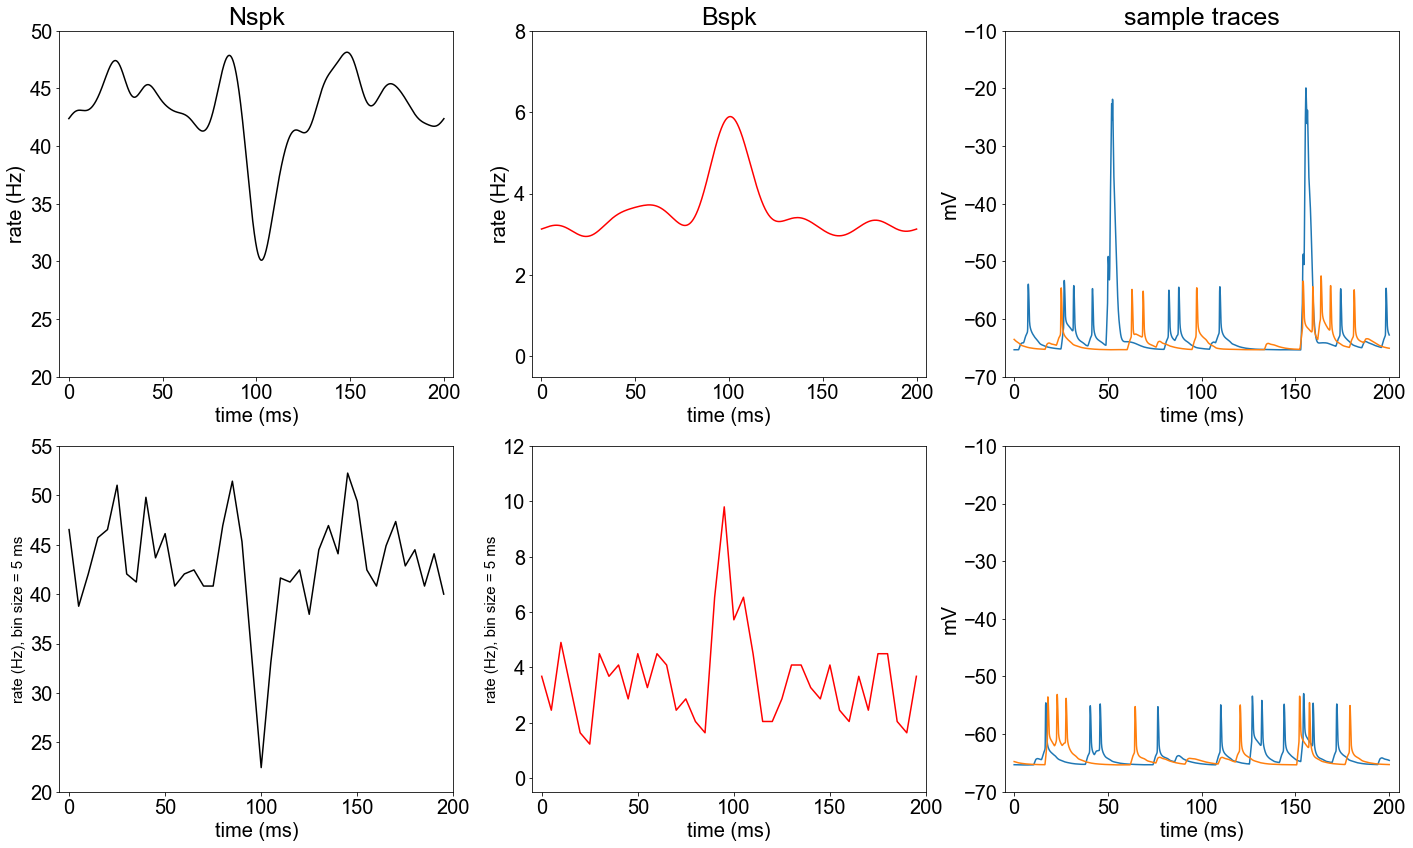

In [15]:
spk_times_soma = turn_trace_to_spk(all_trials, min_hight_nspk = -60, min_hight_bspk = -40,\
                                   prom_nspk = .5, prom_bspk = 15)
spk_rates_soma = make_spk_rate(spk_times_soma, trial_length_dt,Method = 'wrap',Nspk_time_ms = 5, Bspk_time_ms = 10)

bins_ms = 5 #ms
nr_iter = len(all_trials)
bin_Nspk = bin_data(spk_rates_soma['Nspk_number'],eliminate_trials = 0,trial_length = bins_ms)
bin_Bspk = bin_data(spk_rates_soma['Bspk_number'],eliminate_trials = 0,trial_length = bins_ms)

fs = 20
ts = 25

%matplotlib inline
fig = plt.figure(figsize=(24,14)) # Default figsize is (8,6)
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)

plt.subplot(2,3,3)
rnd_num = np.random.randint(0,len(all_trials),2);
for ii in rnd_num:
    print(ii)
    plt.plot(all_trials[ii])
locs, labels = plt.xticks()
dt = 0.025
ticknames = np.require(locs*dt,dtype=np.int)
plt.xticks(locs, ticknames)
plt.ylabel('mV', fontsize=fs)
plt.xlabel('time (ms)', fontsize=fs)
plt.title('sample traces', fontsize=ts)
plt.ylim([-70,-10])
plt.xlim([-5/dt,205/dt])

plt.subplot(2,3,6)
rnd_num = np.random.randint(0,len(all_trials),2);
for ii in rnd_num:
    print(ii)
    plt.plot(all_trials[ii])
locs, labels = plt.xticks()
dt = 0.025
ticknames = np.require(locs*dt,dtype=np.int)
plt.xticks(locs, ticknames)
plt.ylabel('mV', fontsize=fs)
plt.xlabel('time (ms)', fontsize=fs)
plt.ylim([-70,-10])
plt.xlim([-5/dt,205/dt])

plt.subplot(2,3,1)
plt.plot(spk_rates_soma['Nspk_rate_smoothed'],'k')
locs, labels = plt.xticks()
dt = 0.025
ticknames = np.require(locs*dt,dtype=np.int)
plt.xticks(locs, ticknames)
plt.ylabel('rate (Hz)', fontsize=fs)
plt.xlabel('time (ms)', fontsize=fs)
plt.ylim([20,50])
plt.title('Nspk', fontsize=ts)
plt.xlim([-5/dt,205/dt])

plt.subplot(2,3,4)
plt.plot(bin_Nspk/nr_iter/(bins_ms*0.001),'k')
locs, labels = plt.xticks()
ticknames = np.require(locs*bins_ms,dtype=np.int)
plt.xticks(locs, ticknames)
plt.ylabel('rate (Hz), bin size = {} ms'.format(bins_ms), fontsize=15)
plt.xlabel('time (ms)',fontsize=fs)
plt.ylim([20,55])
plt.xlim([-1,len(bin_Nspk)])

plt.subplot(2,3,2)
plt.plot(spk_rates_soma['Bspk_rate_smoothed'],'r')
locs, labels = plt.xticks()
dt = 0.025
ticknames = np.require(locs*dt,dtype=np.int)
plt.xticks(locs, ticknames)
plt.ylabel('rate (Hz)', fontsize=fs)
plt.xlabel('time (ms)', fontsize=fs)
plt.ylim([-0.5, 8])
plt.title('Bspk', fontsize=ts)
plt.xlim([-5/dt,205/dt])

plt.subplot(2,3,5)
plt.plot(bin_Bspk/nr_iter/(bins_ms*0.001),'r')
locs, labels = plt.xticks();
ticknames = np.require(locs*bins_ms,dtype=np.int)
plt.xticks(locs, ticknames)
plt.ylabel('rate (Hz), bin size = {} ms'.format(bins_ms), fontsize=15)
plt.xlabel('time (ms)', fontsize=fs)
plt.ylim([-0.5,12])
plt.xlim([-1,len(bin_Bspk)])
